In [1]:
%%HTML
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

## import 

In [2]:
from lib.io import load_pickle_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from lib.noglobal import noglobal
import glob
from scipy import optimize

## データ取得

In [3]:
train_path = "/work/data/input/selfmade_dataset/baseline_with_derived_data_v1/train.pkl"
test_path = "/work/data/input/selfmade_dataset/baseline_with_derived_data_v1/test.pkl"
train_df = load_pickle_data(train_path)
test_df = load_pickle_data(test_path)

In [4]:
train_df.head(3)

,phone,millisSinceGpsEpoch,latDeg_gt,lngDeg_gt,latDeg,lngDeg,heightAboveWgs84EllipsoidM,prev_lat,prev_lng,prev_heightAboveWgs84EllipsoidM,...,svid_ySatPosM_35,svid_zSatPosM_35,svid_correctedPrM_36,svid_xSatPosM_36,svid_ySatPosM_36,svid_zSatPosM_36,svid_correctedPrM_37,svid_xSatPosM_37,svid_ySatPosM_37,svid_zSatPosM_37
0,2020-06-04-US-MTV-1_Pixel4,1275339493441,37.416314,-122.080465,37.416345,-122.080528,-18.41,0.000000,0.000000,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-06-04-US-MTV-1_Pixel4,1275339494441,37.416314,-122.080465,37.416355,-122.080497,-27.23,37.416345,-122.080528,-18.41,...,NaN,NaN,2.577044e+07,9.890397e+06,-1.392281e+07,2.417928e+07,NaN,NaN,NaN,NaN
2,2020-06-04-US-MTV-1_Pixel4,1275339495441,37.416314,-122.080465,37.416346,-122.080499,-23.34,37.416355,-122.080497,-27.23,...,NaN,NaN,2.577087e+07,9.892769e+06,-1.392229e+07,2.417861e+07,NaN,NaN,NaN,NaN


## 欠損値処理

### 欠損値0で埋める

In [5]:
!ls /work/analysis/first_EDA/Derived_data/Graph/MissingValue

欠損値0補完  欠損値処理なし


In [6]:

@noglobal()
def plot_missing_value_to_zero(dataframe_,output_sateraite_idx):
    df = dataframe_.copy()
    
    svid_Prm_list = sum( [["svid_xSatPosM_"+str(idx),"svid_ySatPosM_"+str(idx),"svid_zSatPosM_"+str(idx),"svid_correctedPrM_"+str(idx)] for idx in range(1,38)], [])

    n_of_unique_route = len(df["phone"].unique().tolist());
    
    output_sateraite_column = ["svid_xSatPosM_"+str(output_sateraite_idx),"svid_ySatPosM_"+str(output_sateraite_idx),"svid_zSatPosM_"+str(output_sateraite_idx),"svid_correctedPrM_"+str(output_sateraite_idx)]

    fig, axis = plt.subplots(n_of_unique_route, 4, figsize=(8*len(output_sateraite_column),8*n_of_unique_route))

    for idx,(key, each_df) in tqdm(enumerate(df.groupby("phone")),total=73 ):
        
        df = each_df.copy().fillna(0)
        

        for col_idx,column_col in enumerate(output_sateraite_column):
            df[column_col].plot(ax = axis[idx][col_idx],title=str(key)+"_"+column_col)
            
        
    fig.savefig("/work/analysis/first_EDA/Derived_data/Graph/MissingValue/sateraite_"+str(output_sateraite_idx)+".png")
    
@noglobal()
def plot_missing_value(dataframe_,output_sateraite_idx):
    df = dataframe_.copy()
    
    svid_Prm_list = sum( [["svid_xSatPosM_"+str(idx),"svid_ySatPosM_"+str(idx),"svid_zSatPosM_"+str(idx),"svid_correctedPrM_"+str(idx)] for idx in range(1,38)], [])

    n_of_unique_route = len(df["phone"].unique().tolist());
    
    output_sateraite_column = ["svid_xSatPosM_"+str(output_sateraite_idx),"svid_ySatPosM_"+str(output_sateraite_idx),"svid_zSatPosM_"+str(output_sateraite_idx),"svid_correctedPrM_"+str(output_sateraite_idx)]

    fig, axis = plt.subplots(n_of_unique_route, 4, figsize=(8*len(output_sateraite_column),8*n_of_unique_route))

    for idx,(key, each_df) in tqdm(enumerate(df.groupby("phone")),total=73 ):
        
        df = each_df.copy()
        

        for col_idx,column_col in enumerate(output_sateraite_column):
            df[column_col].plot(ax = axis[idx][col_idx],title=str(key)+"_"+column_col);
            
        
    fig.savefig("/work/analysis/first_EDA/Derived_data/Graph/MissingValue/sateraite_"+str(output_sateraite_idx)+".png")
            
            

In [7]:
#for idx in tqdm(range(1,38)):
#    plot_missing_value_to_zero(train_df,idx)

def fit_func(parameter,x,y):
        a = parameter[0];
        b = parameter[1];
        c = parameter[2];
        return y - (a*x**2 + b*x + c);


### 最小２乗法による補完

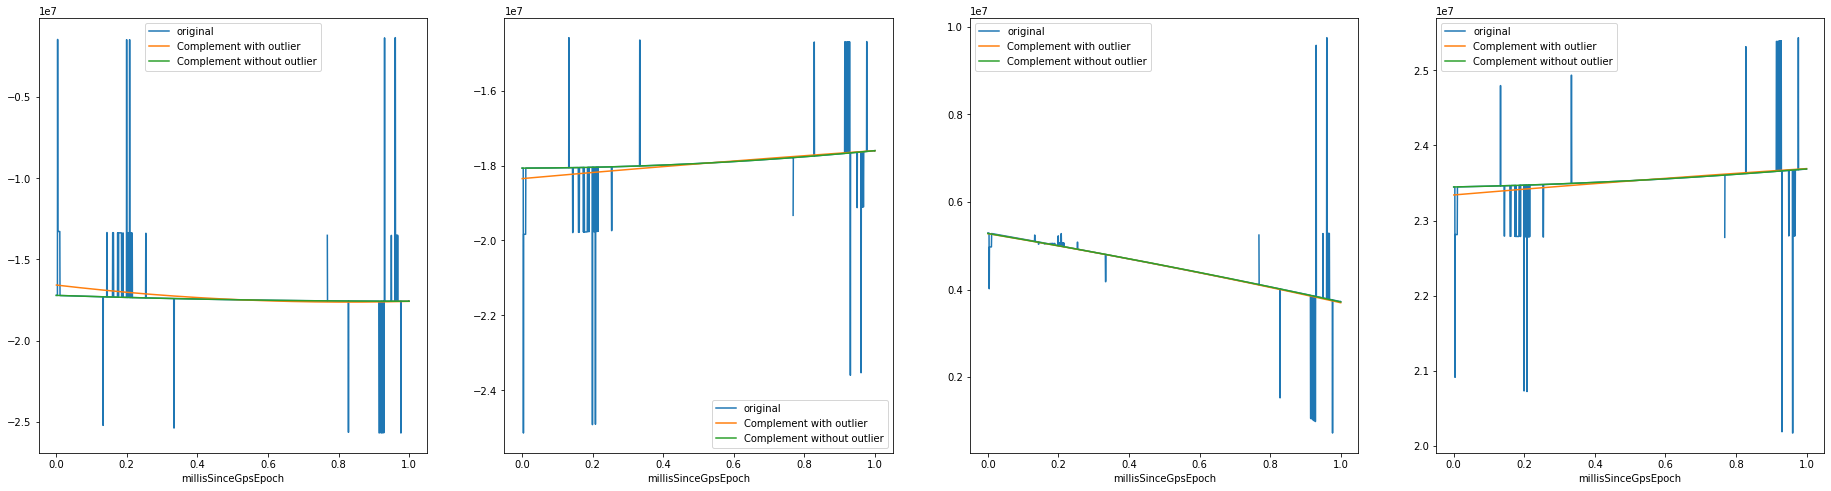

In [8]:
train_df = load_pickle_data(train_path)
train_df = train_df[train_df["phone"].str.contains("2020-05-14-US-MTV-2")]

train_df["phoneInfo"] = train_df["phone"].apply(lambda x: x.split("_")[1])

train_df = train_df[train_df["phoneInfo"] == "Pixel4"]


n_of_unique_route = 1;
output_sateraite_column = 4

fig, axis = plt.subplots(n_of_unique_route, 4, figsize=(8*output_sateraite_column,8*n_of_unique_route))
svid_Prm_list = sum( [["svid_xSatPosM_"+str(idx),"svid_ySatPosM_"+str(idx),"svid_zSatPosM_"+str(idx),"svid_correctedPrM_"+str(idx)] for idx in range(1,2)], [])


train_df["millisSinceGpsEpoch"] = (train_df["millisSinceGpsEpoch"] - train_df["millisSinceGpsEpoch"].min())/(train_df["millisSinceGpsEpoch"].max() - train_df["millisSinceGpsEpoch"].min())    
train_df = train_df.set_index("millisSinceGpsEpoch")
for Prm_idx, PrmValue in enumerate(svid_Prm_list):        
            
    
    train_df[PrmValue].plot(ax=axis[Prm_idx],label="original")
    
    parameter0 = [0.0,0.0,0.0]
    
    each = train_df.dropna(subset=[PrmValue]).copy()
    result = optimize.leastsq(fit_func,parameter0,args=(each.index.values,each[PrmValue].values))[0]
        
    each["Complement"] = result[0]*each.index**2 + result[1]*each.index + result[2]
    
    each["residual"] = each[PrmValue] - each["Complement"] 
    
    mean_value = each["residual"].mean()
    std = each["residual"].std()
        
    each = each[ (each["residual"] < mean_value + std)  & (each["residual"] > mean_value - std)]
    
            
    #each["raian"].plot(ax=axis[1][Prm_idx])
    each["Complement"].plot(ax=axis[Prm_idx],label ="Complement with outlier")
    parameter0 = [0.0,0.0,0.0]    
    result_2nd = optimize.leastsq(fit_func,parameter0,args=(each.index.values,each[PrmValue].values))[0]
        
    train_df["Complement2"] = result_2nd[0]*train_df.index**2 + result_2nd[1]*train_df.index + result_2nd[2]
    train_df["Complement2"].plot(ax=axis[Prm_idx],label ="Complement without outlier")

    ## 凡例表示
    axis[Prm_idx].legend()
    
    


In [9]:
  
@noglobal()
def get_leastsq_per_column(df_arg,xcolumn,ycolumn,plot_flag = False,norm_flag = True):
    """    
        df[column]をハズレ値を考慮して最小二乗法で２次関数で補完するメソッド
                        
    """  
    
    def Quadratic_function(parameter,x,y):
        a = parameter[0];
        b = parameter[1];
        c = parameter[2];
        return y - (a*x**2 + b*x + c);
    
        
    df = df_arg.copy();
    ### 時間に対してmin maxで正規化を行う。
    ### (値が大きいとオーバフローになる可能性が高いため。)
    ### 
    
    if (norm_flag):        
        df["Norm_"+xcolumn] = (df[xcolumn] - df[xcolumn].min())/(df[xcolumn].max() - df[xcolumn].min());
    else:
        df["Norm_"+xcolumn] = df[xcolumn];
                        
    ## column列に欠損値を含むデータを削除　（最小２乗法で使用できないため。）
    df_for_calc = df.dropna(subset=[ycolumn]).copy();
              
    ## 最小２乗法のによる補完
    least_seq_param1 = [0.,0.,0.];    
    result = optimize.leastsq(Quadratic_function,least_seq_param1,args=(df_for_calc["Norm_"+xcolumn].values,df_for_calc[ycolumn].values))[0];
    df_for_calc["Complement1"] = result[0]*df_for_calc["Norm_"+xcolumn].values**2 + result[1]*df_for_calc["Norm_"+xcolumn].values + result[2];
    
        
    ## Complement1ではハズレ値も最小二乗法の計算に組み込まれるので、精度があまり良くない。
    ## そこで、残差が一定の値以上のものを最小二乗法の計算に組み込まないようにした。
    
    ### 残差計算
    df_for_calc["residual"] = df_for_calc[ycolumn] - df_for_calc["Complement1"];
    
    ### 残差平均と残差標準偏差を取得    
    mean_value = df_for_calc["residual"].mean();
    std = df_for_calc["residual"].std();
    
    ### 残差平均 +- 標準偏差内に含まれないデータはハズレ値だと判断して削除
    df_for_calc = df_for_calc[ (df_for_calc["residual"] < mean_value + std)  & (df_for_calc["residual"] > mean_value - std)];
    
    ## 再度、最小二乗法による補完を行う。
    least_seq_param2 = [0.0,0.0,0.0];
    result_2nd = optimize.leastsq(Quadratic_function,least_seq_param2,args=(df_for_calc["Norm_"+xcolumn].values,df_for_calc[ycolumn].values))[0];
    df["Complement2"] = result_2nd[0]*df["Norm_"+xcolumn].values**2 + result_2nd[1]*df["Norm_"+xcolumn].values + result_2nd[2];
        
    if (plot_flag):
        fig, axis = plt.subplots(1, 1, figsize=(8,8));
        
        df[ycolumn].plot(ax=axis,label="original");    
        df_for_calc["Complement1"].plot(ax=axis,label ="Complement with outlier");
        df["Complement2"].plot(ax=axis,label ="Complement without outlier");
        axis.legend();
    
    return df["Complement2"];

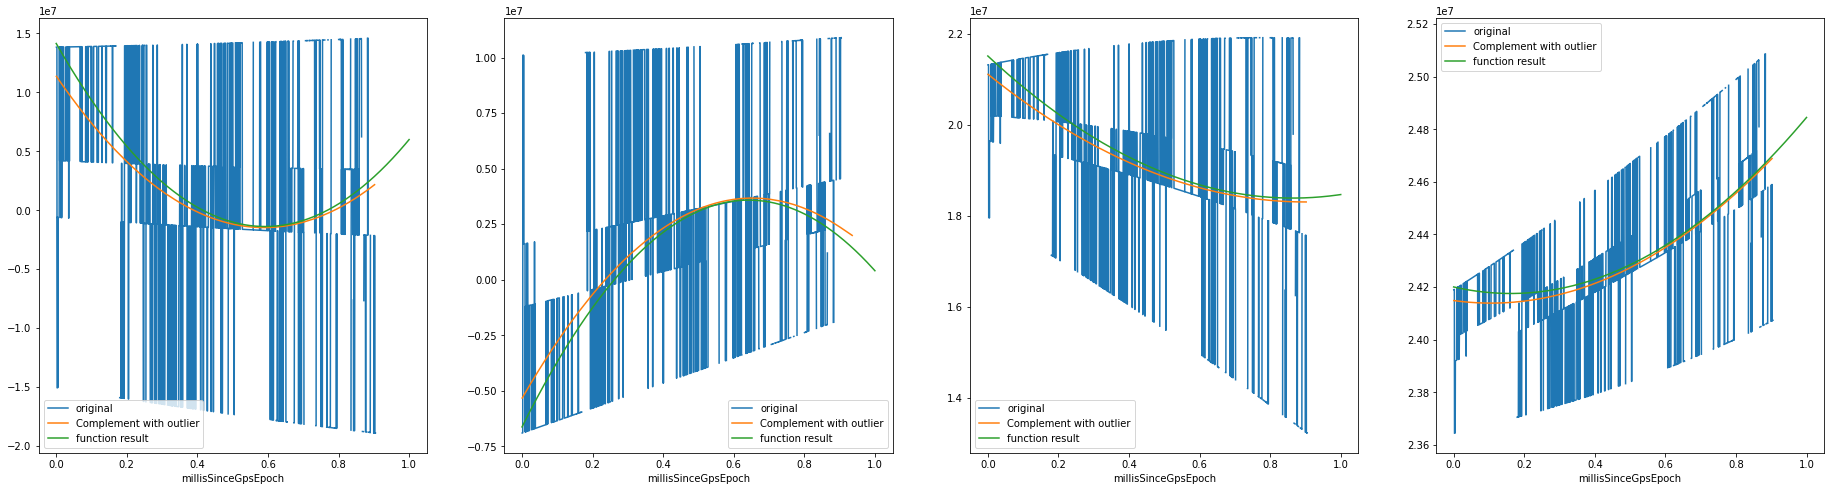

In [29]:
route_path = "2020-05-21-US-MTV-1"
sate_id = 1

train_df = load_pickle_data(train_path)
train_df = train_df[train_df["phone"].str.contains(route_path)]
train_df["phoneInfo"] = train_df["phone"].apply(lambda x: x.split("_")[1])
train_df = train_df[train_df["phoneInfo"] == "Pixel4"]


n_of_unique_route = 1;
output_sateraite_column = 4

fig, axis = plt.subplots(n_of_unique_route, 4, figsize=(8*output_sateraite_column,8*n_of_unique_route))
svid_Prm_list = sum( [["svid_xSatPosM_"+str(idx),"svid_ySatPosM_"+str(idx),"svid_zSatPosM_"+str(idx),"svid_correctedPrM_"+str(idx)] for idx in range(sate_id,sate_id+1)], [])

xcolumn = "millisSinceGpsEpoch"
train_df[xcolumn] = (train_df[xcolumn] - train_df[xcolumn].min())/(train_df[xcolumn].max() - train_df[xcolumn].min());        

for Prm_idx, PrmValue in enumerate(svid_Prm_list):        
                
    
    
    parameter0 = [0.0,0.0,0.0]
    
    each = train_df.dropna(subset=[PrmValue]).copy()
    result = optimize.leastsq(fit_func,parameter0,args=(each.index.values,each[PrmValue].values))[0]
        
    each["Complement"] = result[0]*each.index**2 + result[1]*each.index + result[2]    
    each["residual"] = each[PrmValue] - each["Complement"] 
    
    mean_value = each["residual"].mean()
    std = each["residual"].std()
        
    each = each[ (each["residual"] < mean_value + std)  & (each["residual"] > mean_value - std)]
    
            
    #each["raian"].plot(ax=axis[1][Prm_idx])
    
    parameter0 = [0.0,0.0,0.0]    
    result_2nd = optimize.leastsq(fit_func,parameter0,args=(each.index.values,each[PrmValue].values))[0]
        
    train_df["Complement2"] = result_2nd[0]*train_df.index**2 + result_2nd[1]*train_df.index + result_2nd[2]
    #train_df["Complement2"].plot(ax=axis[Prm_idx],label ="Complement without outlier")
    

        
    train_df["test"] = get_leastsq_per_column(train_df,"millisSinceGpsEpoch",PrmValue,norm_flag = True);    
    
    
    train_df.set_index(xcolumn)[PrmValue].plot(ax=axis[Prm_idx],label="original")    
    each.set_index(xcolumn)["Complement"].plot(ax=axis[Prm_idx],label ="Complement with outlier")
    train_df.set_index(xcolumn)["test"].plot(ax=axis[Prm_idx],label ="function result")
        
        
    ## 凡例表示
    axis[Prm_idx].legend()
    
    

In [17]:
svid_Prm_list = sum( [["svid_xSatPosM_"+str(idx),"svid_ySatPosM_"+str(idx),"svid_zSatPosM_"+str(idx),"svid_correctedPrM_"+str(idx)] for idx in range(1,2)], [])

train_df = load_pickle_data(train_path)
train_df = train_df[train_df["phone"].str.contains("2020-05-14-US-MTV-2")]
train_df["phoneInfo"] = train_df["phone"].apply(lambda x: x.split("_")[1])
train_df = train_df[train_df["phoneInfo"] == "Pixel4"]



train_df["asdf"] = get_leastsq_per_column(train_df,"millisSinceGpsEpoch","svid_xSatPosM_1",plot_flag =False,norm_flag = True)



## ハズレ値が激しい結果の原因推定

### 気になるポイント1: missisSinceGps Epochが同じ値、かつ同じサテライトから複数の信号を受信している。

In [ ]:
!ls /work/data/input/google-smartphone-decimeter-challenge/train/2021-01-04-US-RWC-1/

In [ ]:
data_path = "/work/data/input/google-smartphone-decimeter-challenge/train/2021-01-04-US-RWC-1/Pixel4XL/Pixel4XL_derived.csv"

df = pd.read_csv(data_path);

for key,each_df in df.groupby(["millisSinceGpsEpoch"]):
    display(each_df)
    
    svids = each_df["svid"].duplicated();
    
    
    
    break;

### 特に都心部というわけではない。

In [ ]:
from external_lib.visualize import visualize_trafic

df_truth = pd.read_csv("/work/data/input/google-smartphone-decimeter-challenge/train/2021-01-04-US-RWC-1/Pixel4/ground_truth.csv");
visualize_trafic(df_truth)

In [1]:
from external_lib.visualize import get_googlemap_url
get_googlemap_url(df_truth,zoom=15)

NameError: name 'df_truth' is not defined